# Project 3: Model Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Read in the data

In [2]:
df = pd.read_csv('../data/conversations_clean.csv', na_filter = False)

In [3]:
df.head(3)

,author,comts_first,comts_num_collected,comts_second,created,edited,name,num_comments,permalink,selftext,subreddit,title,ups,url,text,is_serious
0,FetusGodJim,this made me smile ty for sharing i absolutely...,31,i couldn t find anywhere else to share it and ...,1.554138e+09,False,t3_b8509z,146,/r/CasualConversation/comments/b8509z/man_i_fe...,alright so i recently started working my first...,CasualConversation,man i felt so cool yesterday,4467,https://www.reddit.com/r/CasualConversation/co...,man i felt so cool yesterdayalright so i recen...,0
1,goat_chortle,that s a tremendous milestone see you next yea...,31,you bet i don t think that will be a problem e...,1.554144e+09,False,t3_b86ngu,84,/r/CasualConversation/comments/b86ngu/yay_me_t...,no it s not an april fool s joke lol i actuall...,CasualConversation,yay me today marks 1yr cigarette free,2083,https://www.reddit.com/r/CasualConversation/co...,yay me today marks 1yr cigarette freeno it s n...,0
2,IFartedInMyHeart,i think you have no other choice but to make u...,9,great idea,1.554205e+09,False,t3_b8i03a,9,/r/CasualConversation/comments/b8i03a/cat_school/,found out my daughter thinks when the cat goes...,CasualConversation,cat school,34,https://www.reddit.com/r/CasualConversation/co...,cat schoolfound out my daughter thinks when th...,0


### Lemmatize Text Column

In [4]:
# Function to lemmatize a string
from nltk.stem import WordNetLemmatizer

def lemmatize_text(raw_text):
    
    # Split and lemmatize
    lem = WordNetLemmatizer()
    text_lemmed = [lem.lemmatize(word) for word in raw_text.split()]

    # Join back together into a string and return
    return(" ".join(text_lemmed))

In [5]:
df['text_lem'] = df['text'].apply(lemmatize_text) 

### Add Character Count Column

In [6]:
# Add new column
df['char_count_text'] = df['text'].apply(len)

In [7]:
df[['char_count_text', 'text']].head()

,char_count_text,text
0,4862,man i felt so cool yesterdayalright so i recen...
1,6225,yay me today marks 1yr cigarette freeno it s n...
2,1105,cat schoolfound out my daughter thinks when th...
3,1425,april fools really bothers me because it prett...
4,2104,out of all of the madness i cannot believe tha...


In [8]:
df[['char_count_text', 'is_serious']].groupby(by='is_serious').mean()

,char_count_text
is_serious,
0,2741.703890
1,6028.018952


In [9]:
# Correlation with target
df[['char_count_text', 'is_serious']].corr()['is_serious'].sort_values()

char_count_text    0.404315
is_serious         1.000000
Name: is_serious, dtype: float64

Observation: char_count on all the combined text is highly correlated with serious posts
- Note: Even though not all comments were collected I had the same max and the same level of comments collected on each post

### Add Sentiment Analysis Column

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [11]:
sia = SentimentIntensityAnalyzer()

In [12]:
dicts = []

for st in df['text']:
    scores = sia.polarity_scores(st)  
    scores['text'] = st
    dicts.append(scores)

In [13]:
df_sent = pd.DataFrame(dicts)
df_sent['target'] = df['is_serious']

In [14]:
df_sent.head()

,compound,neg,neu,pos,text,target
0,0.9997,0.066,0.661,0.273,man i felt so cool yesterdayalright so i recen...,0
1,0.9999,0.057,0.649,0.293,yay me today marks 1yr cigarette freeno it s n...,0
2,0.9195,0.068,0.820,0.112,cat schoolfound out my daughter thinks when th...,0
3,-0.9943,0.221,0.709,0.071,april fools really bothers me because it prett...,0
4,0.9988,0.080,0.636,0.284,out of all of the madness i cannot believe tha...,0


In [15]:
df_sent.groupby(by='target').mean()

,compound,neg,neu,pos
target,,,,
0,0.772786,0.074774,0.745668,0.179552
1,0.390292,0.110882,0.739592,0.149513


In [16]:
df.shape

(1694, 18)

In [17]:
# Insert sentiment analysis columns
df.insert(0, 'sent_compound', df_sent['compound'])
df.insert(1, 'sent_neg', df_sent['neg'])
df.insert(2, 'sent_neu', df_sent['neu'])
df.insert(3, 'sent_pos', df_sent['pos'])

In [18]:
df.shape

(1694, 22)

In [19]:
# Correlation with target
df[['sent_compound', 'sent_neg', 'sent_neu', 'sent_pos', 'is_serious']].corr()['is_serious'].sort_values()

sent_pos        -0.257512
sent_compound   -0.253010
sent_neu        -0.048992
sent_neg         0.371723
is_serious       1.000000
Name: is_serious, dtype: float64

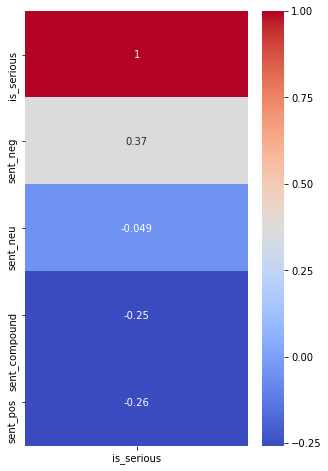

In [20]:
plt.figure(figsize=(5,8))
sns.heatmap(df[['sent_compound', 'sent_neg', 'sent_neu', 'sent_pos', 'is_serious']].corr()[['is_serious']].sort_values('is_serious', ascending=False),
            annot=True, cmap='coolwarm');

### Baseline Accuracy

In [21]:
print('Baseline Accuracy: ', df['is_serious'].value_counts(normalize=True).values[0])

Baseline Accuracy:  0.5295159386068476


### Baseline Model Score - Logistic Regression using Sentiment as Features

In [22]:
X = df[['sent_neg', 'sent_pos']]
y = df['is_serious']

In [23]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [24]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)

print('Cross Val Score: ', cross_val_score(lr, X_train, y_train, cv=5).mean())
print('Train Score:     ', lr.score(X_train, y_train))
print('Test Score:      ', lr.score(X_test, y_test))

Cross Val Score:  0.6724771813427994
Train Score:      0.6787401574803149
Test Score:       0.6273584905660378


Observation: this is a good improvement from our baseline accuracy score of 0.529
- Note: this is only using Logistic Regression...have not yet tried other models

In [25]:
print(f'Improvment: {round((0.6724771813427994 - 0.5295159386068476) / 0.5295159386068476 * 100, 2)}%')

Improvment: 27.0%


In [26]:
# Coefficient Interpretation
print(f'A 1 unit increase in sent_neg mean that the post is {np.exp(lr.coef_)[0][0]} times as likely to be serious')
print(f'A 1 unit increase in sent_pos mean that the post is {np.exp(lr.coef_)[0][1]} times as likely to be serious')

A 1 unit increase in sent_neg mean that the post is 611.6244033730949 times as likely to be serious
A 1 unit increase in sent_pos mean that the post is 0.017719862995631747 times as likely to be serious


### Baseline Model Score - Logistic Regression using Sentiment & Char Count as Features

In [27]:
X = df[['sent_neg', 'sent_pos', 'char_count_text']]
y = df['is_serious']

In [28]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [29]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)

print('Cross Val Score: ', cross_val_score(lr, X_train, y_train, cv=5).mean())
print('Train Score:     ', lr.score(X_train, y_train))
print('Test Score:      ', lr.score(X_test, y_test))

Cross Val Score:  0.7197807993135943
Train Score:      0.7047244094488189
Test Score:       0.660377358490566


In [30]:
print(f'Improvment: {round((0.7197807993135943 - 0.5295159386068476) / 0.5295159386068476 * 100, 2)}%')

Improvment: 35.93%


In [31]:
# Coefficient Interpretation
print(f'A 1 unit increase in sent_neg mean that the post is {np.exp(lr.coef_)[0][0]} times as likely to be serious')
print(f'A 1 unit increase in sent_pos mean that the post is {np.exp(lr.coef_)[0][1]} times as likely to be serious')
print(f'A 1 unit increase in char count means that the post is {np.exp(lr.coef_)[0][2]} times as likely to be serious')

A 1 unit increase in sent_neg mean that the post is 0.984603814937952 times as likely to be serious
A 1 unit increase in sent_pos mean that the post is 0.7363699015753495 times as likely to be serious
A 1 unit increase in char count means that the post is 1.0003653596575002 times as likely to be serious


### Gridsearch with Count Vectorize & Logistic Regression
#### To find best parameters for count vectorize

In [32]:
X = df['text_lem']
y = df['is_serious']

In [33]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [34]:
# Create Pipeline

# pass in a list of different stages you want in your pipelines. Each stage is a tuple. First item in tuple in the string name
pipe = Pipeline([('cvec', CountVectorizer()),
                 ('lr', LogisticRegression(solver='liblinear'))])

In [35]:
params = {
    'cvec__stop_words': ['english'],    # name from pipe + '__' (None is the default)
    'cvec__max_features' : [None, 3000, 4000],
    'cvec__min_df' : [3, 7, 10],
    'cvec__max_df' : [0.7, 0.8, 0.9]
}
gs = GridSearchCV(pipe, param_grid=params, cv=3) # model, params
gs.fit(X_train, y_train) # Also does cv in the background

print('Best Score:  ', gs.best_score_)
print('Best Params: ', gs.best_params_) # cross_val_score (best score from 3 fold cross validation)

Best Score:   0.8433070866141732
Best Params:  {'cvec__max_df': 0.7, 'cvec__max_features': None, 'cvec__min_df': 3, 'cvec__stop_words': 'english'}


### Count Vectorize

In [36]:
cvec = CountVectorizer(stop_words = 'english', 
                       max_features = None, 
                       min_df = 3, 
                       max_df = 0.7)

# Fit Count Vectorizer
all_features = cvec.fit_transform(df['text_lem'])

# Matrix of words to dataframe
df_cv = pd.DataFrame(all_features.toarray(), columns = cvec.get_feature_names())

In [37]:
# Insert target sentiment analysis columns
df_cv.insert(0, 'is_serious', df['is_serious'])
df_cv.insert(1, 'sent_compound', df_sent['compound'])
df_cv.insert(2, 'sent_neg', df_sent['neg'])
df_cv.insert(3, 'sent_neu', df_sent['neu'])
df_cv.insert(4, 'sent_pos', df_sent['pos'])
df_cv.insert(5, 'char_count', df['char_count_text'])

In [38]:
df_cv.head()

,is_serious,sent_compound,sent_neg,sent_neu,sent_pos,char_count,00,000,001,00pm,...,zealand,zen,zeppelin,zero,zip,zoloft,zombie,zone,zoned,zoo
0,0,0.9997,0.066,0.661,0.273,4862,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.9999,0.057,0.649,0.293,6225,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.9195,0.068,0.820,0.112,1105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-0.9943,0.221,0.709,0.071,1425,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0.9988,0.080,0.636,0.284,2104,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
## Save to CSV
df_cv.to_csv('../data/count_vec.csv', index = False)

### Gridsearch with TF-IDF & Logistic Regression
#### To find best parameters for TF-IDF

In [40]:
X = df['text_lem']
y = df['is_serious']

In [41]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [42]:
# Create Pipeline

# pass in a list of different stages you want in your pipelines. Each stage is a tuple. First item in tuple in the string name
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('lr', LogisticRegression(solver='liblinear'))])

In [43]:
params = {
    'tfidf__stop_words': ['english'],    # name from pipe + '__' (None is the default)
    'tfidf__min_df' : [0, 5, 10],
    'tfidf__max_df' : [0.7, 0.8, 0.9, 1.0]
}
gs = GridSearchCV(pipe, param_grid=params, cv=3) # model, params
gs.fit(X_train, y_train) # Also does cv in the background

print('Best Score:  ', gs.best_score_)
print('Best Params: ', gs.best_params_) # cross_val_score (best score from 3 fold cross validation)

Best Score:   0.8519685039370078
Best Params:  {'tfidf__max_df': 0.7, 'tfidf__min_df': 5, 'tfidf__stop_words': 'english'}


### TF-IDF

In [44]:
tfidf = TfidfVectorizer(stop_words = 'english', 
                        #max_features = 4000, 
                        min_df = 5, 
                        max_df = 0.7)

# Fit TF-IDF
tfidif_terms = tfidf.fit_transform(df['text_lem'])

df_tfidif = pd.DataFrame(tfidif_terms.toarray(), columns=tfidf.get_feature_names())

In [45]:
df_tfidif.shape

(1694, 7920)

In [46]:
# Insert target sentiment analysis columns
df_tfidif.insert(0, 'is_serious', df['is_serious'])
df_tfidif.insert(1, 'sent_compound', df_sent['compound'])
df_tfidif.insert(2, 'sent_neg', df_sent['neg'])
df_tfidif.insert(3, 'sent_neu', df_sent['neu'])
df_tfidif.insert(4, 'sent_pos', df_sent['pos'])
df_tfidif.insert(5, 'char_count', df['char_count_text'])

In [47]:
df_tfidif.head()

,is_serious,sent_compound,sent_neg,sent_neu,sent_pos,char_count,00,000,01,02,...,yr,yt,yummy,yup,zealand,zero,zip,zombie,zone,zoo
0,0,0.9997,0.066,0.661,0.273,4862,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,0.9999,0.057,0.649,0.293,6225,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,0.9195,0.068,0.820,0.112,1105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0,-0.9943,0.221,0.709,0.071,1425,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085366,0.0
4,0,0.9988,0.080,0.636,0.284,2104,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [48]:
## Save to CSV
df_tfidif.to_csv('../data/tfidf.csv', index = False)